In [1]:
# Imports.
import sys
print(sys.version)
print()
from collections import deque
import matplotlib.pyplot as plt
import gym
import random
import time
import numpy as np
from tqdm.notebook import trange
import tensorflow as tf
print("Tensorflow", tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
print(tf.config.list_physical_devices('GPU'))
print()
import slimevolleygym

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]

Tensorflow 2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



In [2]:
from IPython import display
from pyvirtualdisplay import Display
displayy = Display(visible=0, size=(1, 1))
displayy.start()
%matplotlib inline

# Deep Q Network Agent

In [3]:
class Agent:
    def __init__(self, state_num, action_num):
        self.action_num = action_num
        self.state_num = state_num
        self.gamma = 0.95 # Discount rate.
        self.replay_batch = 128 # Number of replayed experiences added together.
        self.experiences = deque(maxlen=10000) # Total number of experiences.
        self.episode_experiences = deque()
        
        # Create NN that will act as function approximator for Q[s,a].
        self.model = keras.Sequential()
        # First dense layer with relu activation.
        self.model.add(layers.Dense(400, input_dim=state_num, activation="relu"))
        self.model.add(layers.Dense(100, activation="relu"))
        self.model.add(layers.Dense(action_num, activation="linear"))
        
        # Loss function.
        self.model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.001))
        
        self.model.summary()
        
        self.model_history = []
        
        # Create target model copy.
        self.target_model = keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        self.start_training = False
                
    def ExploitAction(self, state):
        state = np.reshape(state, [1, self.state_num])
        # Take the best possible action.
        action_values = self.model(state, training=False)
        exploit_action_index = np.argmax(action_values[0])
        return exploit_action_index
    
    def ExploreAction(self):
        # Take a random action to explore the [s,a] space.
        return np.random.choice(self.action_num, 1)[0]
    
    def AddExperience(self, s, a, r, s2, episode_over):
        s = np.reshape(s, [1, self.state_num])
        s2 = np.reshape(s2, [1, self.state_num])
        # Add experience to a que.
        self.experiences.append((s, a, r, s2, episode_over))
    
    # This is because we will run fit only once per episode.
    def AddEpisodeExperience(self, s, a, r, s2, episode_over):
        self.episode_experiences.append((s, a, r, s2, episode_over))
        
    def UpdateQ(self):
        # Don't start training until experiences is 25% full.
        if (len(self.experiences) < (self.experiences.maxlen/4)):
            self.experiences.extend(self.episode_experiences)
            self.episode_experiences = deque()
            return
        else:
            if not self.start_training:
                self.start_training = True
                print("Start training.")
        
        # Select from random experiences excluding most recent.
        selected_experiences = random.sample(self.experiences, self.replay_batch)
        # Append most recent experience.
        selected_experiences.extend(self.episode_experiences)
        batch = len(selected_experiences)

        # Collect all next state Q values.
        s_t0s = np.zeros([batch, self.state_num])
        s_t1s = np.zeros([batch, self.state_num])
        for i in range(len(selected_experiences)):
            s_t0s[i] = selected_experiences[i][0]
            s_t1s[i] = selected_experiences[i][3]
        
        a_t1_values = self.target_model.predict(s_t1s)
        max_a_t1_value = np.amax(a_t1_values, axis=1)
        
        targets = self.model.predict(s_t0s)
        states = np.zeros([batch, self.state_num])
        i = 0
        for s_t0, a_t0, r_t0, s_t1, over in selected_experiences:
            states[i] = s_t0
            if (not over):
                targets[i][a_t0] = r_t0 + self.gamma*max_a_t1_value[i]
            else:
                targets[i][a_t0] = r_t0
            i+=1

        output = self.model.fit(states, targets, epochs=1, verbose=0)
            
        self.model_history += [output.history['loss']]
        
        self.episode_experiences = deque()

In [4]:
def PlayEpisode(env, agent, epsilon):
    # Reset playing environment.
    observation = env.reset()
    
    total_episode_reward = 0
    
    episode_done = False
    while not episode_done:
        # Explore or exploit.
        if (random.random() < epsilon):
            # Explore.
            action = agent.ExploreAction()
        else:
            # Exploit.
            action = agent.ExploitAction(observation)
        
        # Perform action and state transition.
        action_reshaped = np.zeros(agent.action_num)
        action_reshaped[action] = 1
        next_observation, reward, episode_done, info = env.step(action_reshaped)
        
        total_episode_reward += reward
        
        # Add to step to experiences.
        agent.AddEpisodeExperience(observation, action, reward, next_observation, episode_done)
        
        # Next observation becomes current.
        observation = next_observation

    # Train once per episode.
    agent.UpdateQ()
    return total_episode_reward

def EvalEpisode(env, agent, episodes):
    total_reward = 0
    for _ in range(episodes):
        observation = env.reset()
        episode_done = False
        i = 0
        while not episode_done:
            action = agent.ExploitAction(observation)
            action_reshaped = np.zeros(agent.action_num)
            action_reshaped[action] = 1
            next_observation, reward, episode_done, info = env.step(action_reshaped)
            total_reward += reward
            observation = next_observation
    return total_reward/episodes

# Create Agent and Environment

In [5]:
env = gym.make('SlimeVolley-v0')
print("Observation Space " + str(env.observation_space.shape))
print("Action Space " + str(env.action_space.shape))

agent = Agent(len(env.observation_space.sample()), env.action_space.n)

Observation Space (12,)
Action Space (3,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               5200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 45,603
Trainable params: 45,603
Non-trainable params: 0
_________________________________________________________________


In [6]:
class BestModel:
    def __init__(self, agent):
        self.best_model = keras.models.clone_model(agent.model)
        self.best_model.set_weights(agent.model.get_weights())
        self.state_num = agent.state_num
        self.best_score = -10
        self.update_index = 0
    def UpdateBest(self, agent, eval_score, i):
        if (eval_score > self.best_score):
            self.best_model.set_weights(agent.model.get_weights())
            self.best_score = eval_score
            self.update_index = i
            print("New best!")
    def RunBest(self, state):
        state = np.reshape(state, [1, self.state_num])
        action = self.best_model(state, training=False)
        return np.argmax(action[0])

bmodel = BestModel(agent)

## Run Training

  0%|          | 0/401 [00:00<?, ?it/s]

Start training.

Episode 100 Eval Avg -5.0
New best!
Elapsed time: 85.08

Episode 200 Eval Avg -4.9
New best!
Elapsed time: 88.78

Episode 300 Eval Avg -4.9
Elapsed time: 93.2

Episode 400 Eval Avg -4.8
New best!
Elapsed time: 99.38


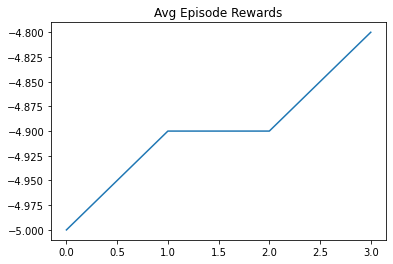

In [7]:
episode_num = 401
start = time.time()

eval_score = []
for i in trange(episode_num):
    # Decay epsilon.
    eps = 1.0/np.sqrt(i+1)
    
    # Play episode.
    PlayEpisode(env, agent, eps)
    if i%10 == 0 and i != 0:
        agent.target_model.set_weights(agent.model.get_weights())

    if i%100 == 0 and i != 0:
        eval_score += [EvalEpisode(env, agent, 10)]
        print("\nEpisode", i, "Eval Avg", eval_score[-1])
        bmodel.UpdateBest(agent, eval_score[-1], i)
        print("Elapsed time:", round(time.time() - start, 2))
        start = time.time()

plt.plot(eval_score)
plt.title("Avg Episode Rewards")
plt.show()

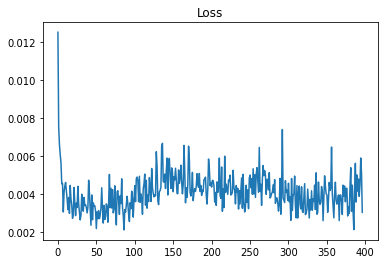

In [8]:
plt.plot(agent.model_history)
plt.title('Loss')
plt.show()

## Watching a Game

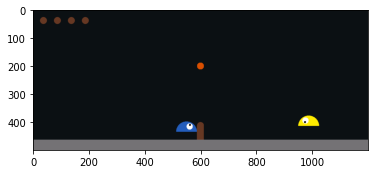

score: -5
400


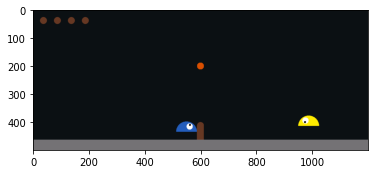

In [9]:
obs = env.reset()
done = False
total_reward = 0
img = plt.imshow(env.render(mode='rgb_array'))

while not done:
    action = bmodel.RunBest(obs)
    action_reshaped = np.zeros(agent.action_num)
    action_reshaped[action] = 1
    obs, reward, done, info = env.step(action_reshaped)
    total_reward += reward
    img.set_data(env.render(mode='rgb_array'))
    display.clear_output(wait=True)
    display.display(plt.gcf())

print("score:", total_reward)
print(bmodel.update_index)